<a href="https://colab.research.google.com/github/scottspurlock/noisy_labels/blob/main/autoencoder_classifier_noisy_labels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Improving noisy label classification with an autoencoder
## Scott Spurlock
### Created: 7/22/2021
If we train a neural network for classification, the latent space defined by the last layer before the classification head shows some clustering based on class label. However, deep networks do not generalize well when labels are noisy (Lee et al. "Robust Inference via Generative Classifiers for Handling Noisy Labels", PMLR 2019). Idea: train an autoencoder to keep the latent space well organized despite label noise (since autoencoder doesn't use labels), and also a classification head to classify based on the latent space.

Initial results suggest that a little noise (10-20%) doesn't have much effect on the model accuracy even without an autoencoder (down from 95 to 93%), while more noise (40\%) drops the accuracy of the basic classifier down to 75%, but adding in the reconstruction doesn't help much (78%). Possibly a bigger effect could be observed with more targeted noise, where one class is only ever swapped with another. Also a VAE might help more with a smooth latent space.


In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [42]:
print(tf.__version__)
!nvidia-smi

2.5.0
Thu Jul 22 22:34:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    32W /  70W |   8010MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-

In [43]:
latent_dim = 2
input_shape = (28, 28, 1)
epochs = 10
batch_size = 128
num_classes = 10
learning_rate = 5e-4

## Define the models

In [44]:
def encoder(input_shape):
    inputs = keras.Input(shape=input_shape, name='input_layer')
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation="relu")(x)
    x = layers.Dense(latent_dim, name='latent_out')(x)
    model = tf.keras.Model(inputs, x, name='encoder')
    return model

In [45]:
def decoder():
    inputs = keras.Input(shape=(latent_dim,), name='input_layer')
    x = layers.Dense(7 * 7 * 64, activation="relu")(inputs)
    x = layers.Reshape((7, 7, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
    model = tf.keras.Model(inputs, outputs, name="decoder")
    return model

In [46]:
def classifier():
    inputs = keras.Input(shape=(latent_dim,), name='input_layer')
    outp = layers.Dense(num_classes, activation="softmax", name='classifier_out')(inputs)
    model = tf.keras.Model(inputs, outp, name="classifier")
    return model

## Data

In [47]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Randomly swap some labels
y_train_orig = y_train.copy()
for i in range(len(y_train)):
  if np.random.randint(0, 100) < 40:
    y_train[i] = np.random.randint(0, 10)

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)


# One-hot encode the labels
y_train_one_hot = keras.utils.to_categorical(y_train, num_classes)
y_test_one_hot = keras.utils.to_categorical(y_test, num_classes)

print('y_train shape:', y_train.shape)
print('y_train_one_hot shape:', y_train_one_hot.shape)

n_train = x_train.shape[0]

x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)
y_train shape: (60000,)
y_train_one_hot shape: (60000, 10)


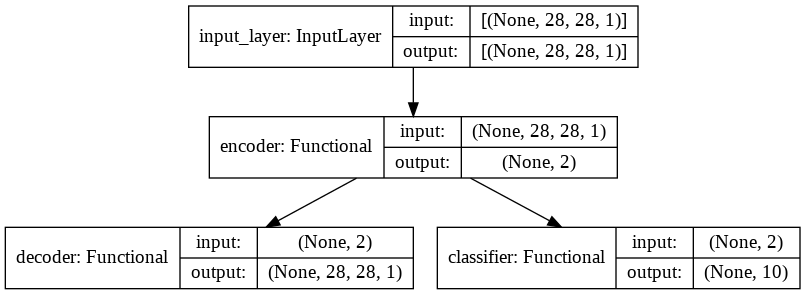

In [48]:
inputs = keras.Input(shape=input_shape, name='input_layer')

enc = encoder(input_shape)
dec = decoder()
clf = classifier()

model = tf.keras.Model(
			inputs=inputs,
			outputs=[dec(enc(inputs)), clf(enc(inputs))],
			name="autoencoder")

# plot the autoencoder
tf.keras.utils.plot_model(model, 'autoencoder_classifier.png', show_shapes=True)

## Train the model

In [56]:
losses = {
    'decoder': 'mse',
    'classifier': 'categorical_crossentropy',
}

wts = {
    'decoder': 10.0, 
    'classifier': 1.0
}

opt = keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=opt, loss=losses, loss_weights=wts, metrics=["accuracy"])
hist = model.fit(x_train, [x_train, y_train_one_hot], batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/10
422/422 [==============================] - 7s 14ms/step - loss: 2.3508 - decoder_loss: 0.0452 - classifier_loss: 1.8987 - decoder_accuracy: 0.7952 - classifier_accuracy: 0.5091 - val_loss: 2.3505 - val_decoder_loss: 0.0436 - val_classifier_loss: 1.9143 - val_decoder_accuracy: 0.7967 - val_classifier_accuracy: 0.5222
Epoch 2/10
422/422 [==============================] - 6s 13ms/step - loss: 2.3447 - decoder_loss: 0.0449 - classifier_loss: 1.8961 - decoder_accuracy: 0.7953 - classifier_accuracy: 0.5179 - val_loss: 2.3515 - val_decoder_loss: 0.0437 - val_classifier_loss: 1.9146 - val_decoder_accuracy: 0.7964 - val_classifier_accuracy: 0.5340
Epoch 3/10
422/422 [==============================] - 6s 13ms/step - loss: 2.3395 - decoder_loss: 0.0446 - classifier_loss: 1.8938 - decoder_accuracy: 0.7955 - classifier_accuracy: 0.5158 - val_loss: 2.3442 - val_decoder_loss: 0.0433 - val_classifier_loss: 1.9116 - val_decoder_accuracy: 0.7973 - val_classifier_accuracy: 0.5280
Epoch 4/10
42

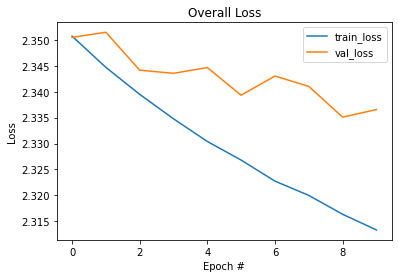

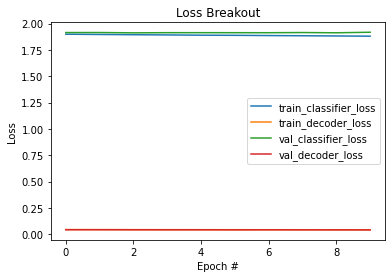

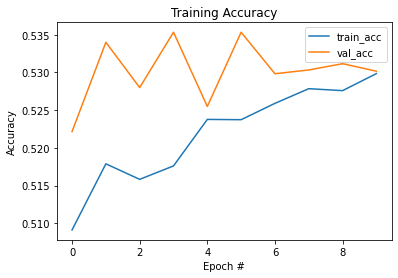

In [57]:
# construct a plot that plots and saves the training history
# plt.style.use("ggplot")
plt.figure()
plt.plot(hist.epoch, hist.history["loss"], label="train_loss")
plt.plot(hist.epoch, hist.history["val_loss"], label="val_loss")
plt.title("Overall Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.savefig('total_loss.png')
plt.show()

plt.figure()
plt.plot(hist.epoch, hist.history["classifier_loss"], label="train_classifier_loss")
plt.plot(hist.epoch, hist.history["decoder_loss"], label="train_decoder_loss")
plt.plot(hist.epoch, hist.history["val_classifier_loss"], label="val_classifier_loss")
plt.plot(hist.epoch, hist.history["val_decoder_loss"], label="val_decoder_loss")
plt.title("Loss Breakout")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.savefig('indiv_loss.png')
plt.show()

plt.figure()
plt.plot(hist.epoch, hist.history["classifier_accuracy"], label="train_acc")
plt.plot(hist.epoch, hist.history["val_classifier_accuracy"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('classifier_acc.png')
plt.show()



Test Accuracy: 0.8085
              precision    recall  f1-score   support

           0       0.73      0.93      0.82       980
           1       0.96      0.99      0.97      1135
           2       0.96      0.95      0.95      1032
           3       0.76      0.97      0.86      1010
           4       0.74      0.32      0.45       982
           5       0.93      0.40      0.56       892
           6       0.82      0.97      0.89       958
           7       0.94      0.93      0.93      1028
           8       0.90      0.68      0.78       974
           9       0.56      0.85      0.67      1009

    accuracy                           0.81     10000
   macro avg       0.83      0.80      0.79     10000
weighted avg       0.83      0.81      0.79     10000



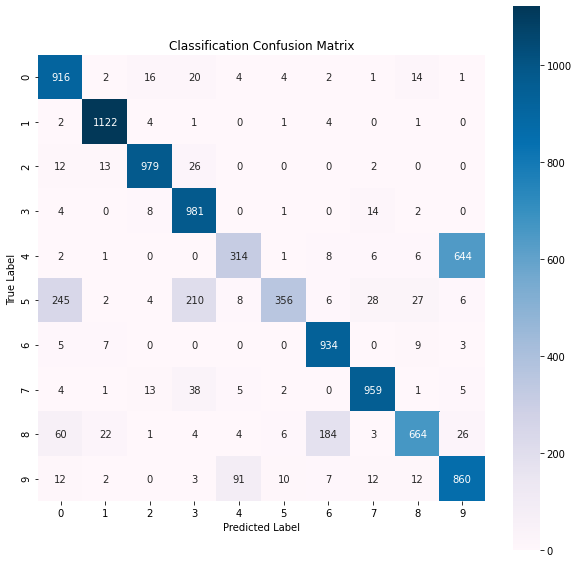

In [58]:
# Check accuracy

# Encode the input image
z = enc(x_test)

# Classify the latent code
y_pred = clf(z)

m = tf.keras.metrics.CategoricalAccuracy()
m.update_state(y_test_one_hot, y_pred)
print('Test Accuracy:', m.result().numpy())

y_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(10, 10))
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True, cmap="PuBu")

plt.xlabel('Predicted Label');
plt.ylabel('True Label')
plt.title('Classification Confusion Matrix')
plt.show()


## Show some reconstructions

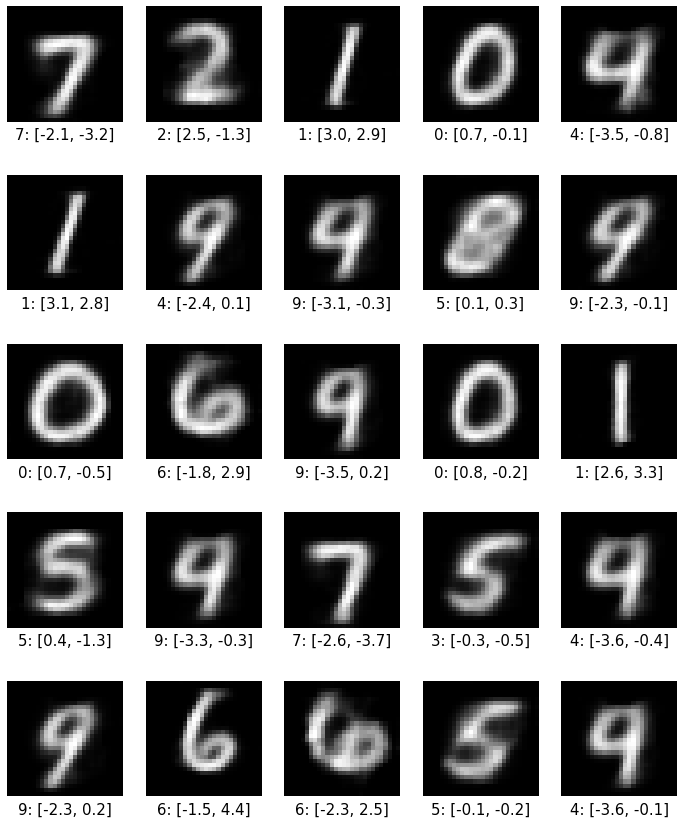

In [59]:
figsize = 12

latent = enc.predict(x_test[:25])
reconst = dec.predict(latent)

fig = plt.figure(figsize=(figsize, 15))
#fig.subplots_adjust(wspace=-0.021)

for i in range(25):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    plt.text(0.5, -0.15, '{}: [{:.1f}, {:.1f}]'.format(y_test[i], latent[i, 0], latent[i, 1]), fontsize=15, ha='center', transform=ax.transAxes)
    #plt.subplots_adjust(wspace=None, hspace=None)
    plt.imshow(reconst[i, :,:,0]*255, cmap = 'gray')
plt.show()

## Display how the latent space clusters different digit classes

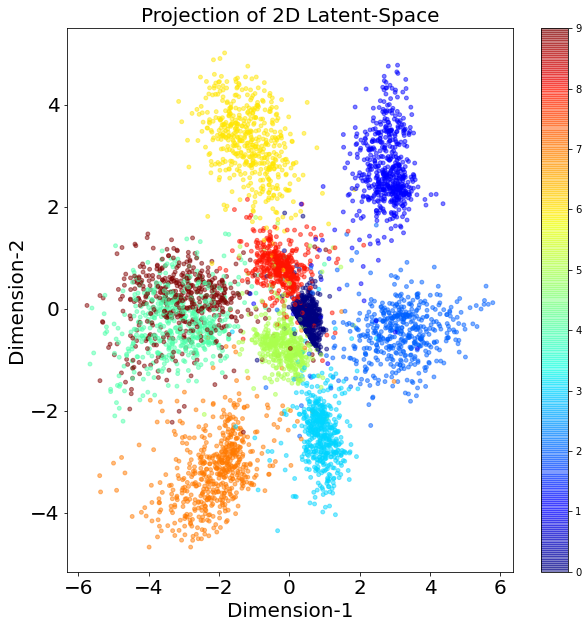

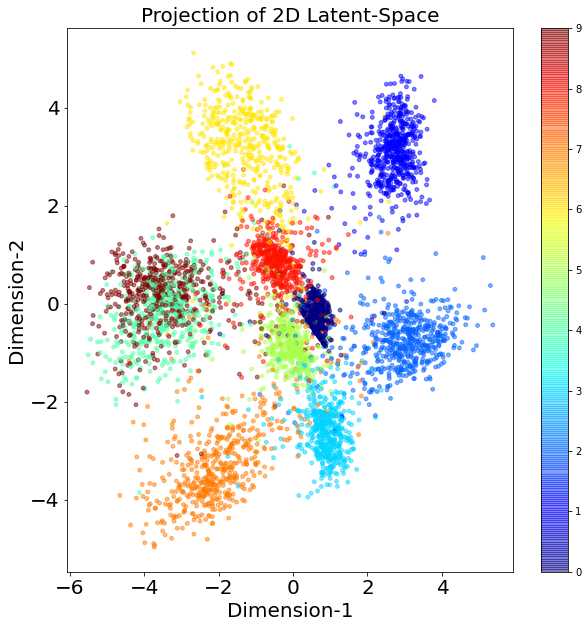

In [60]:
imgs_visualize = 5000
figsize = 10

def plot_label_clusters(data, labels, use_pca=False):
    # display a 2D plot of the digit classes in the latent space
    z = enc.predict(data)

    if use_pca:
      pca = PCA(n_components=2)
      pca.fit(data)
      z = pca.transform(z)


    plt.figure(figsize=(figsize, figsize))
    plt.scatter(z[:, 0], z[:, 1], 15, c=labels, cmap='jet', alpha=0.5)
    plt.colorbar()
    plt.xlabel("Dimension-1", size=20)
    plt.ylabel("Dimension-2", size=20)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.title("Projection of 2D Latent-Space", size=20)
    plt.show()

plot_label_clusters(x_train[:imgs_visualize], y_train_orig[:imgs_visualize])
plot_label_clusters(x_test[:imgs_visualize], y_test[:imgs_visualize])


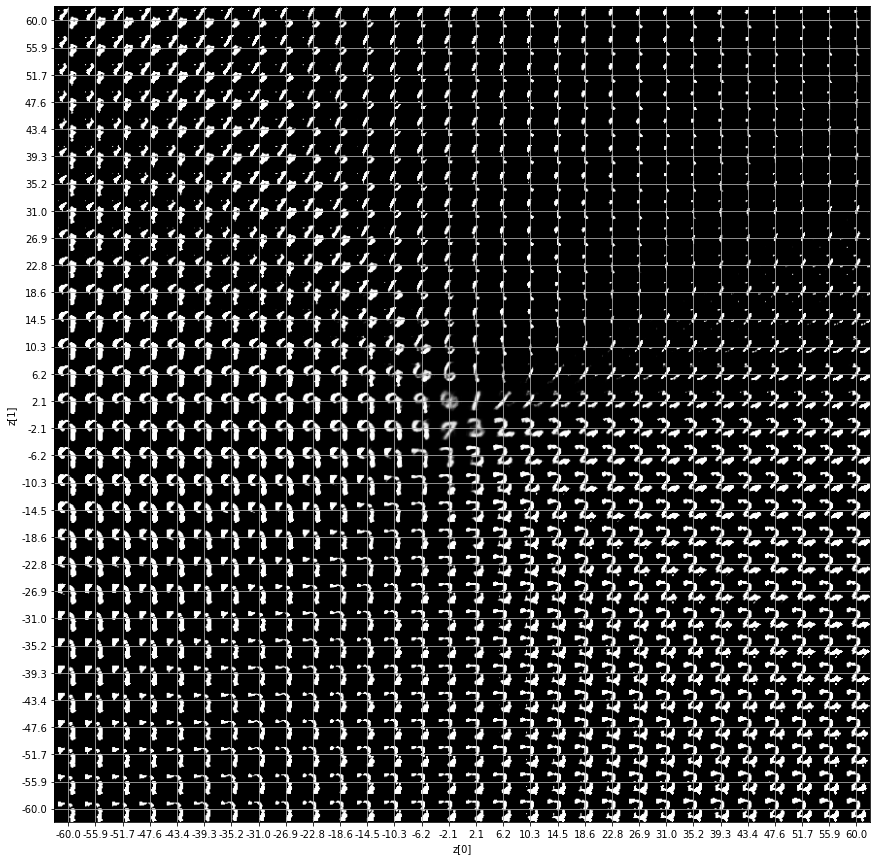

In [61]:
def plot_latent_space(model, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 60.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = dec.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.grid('off')
    plt.show()


plot_latent_space(model)

In [62]:
!nvidia-smi


Thu Jul 22 22:40:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    32W /  70W |   8010MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------